In [20]:
'''
important finding: In the hirex data only every fourth image corresponds to a spectrum. It records for the maximum rate.
First spectrum seems to be at index 20
'''
import data_helper as dh
import numpy as np
import matplotlib.pyplot as plt
trains_dh=dh.train_source(run=8)
hist=dh.Histogrammer(bins=100, range=(10,500))

def check_for_spectrum(line):
    histogram=hist(line)
    return np.sum(histogram>80)> 10

In [21]:

def autocorrelate(spectrum):
    return np.correlate(spectrum, spectrum, mode="full")

def mean_autocorrelation_train(train):
    
    for i in range(len([''])):
        max_img.accumulate()



In [ ]:
data=next(trains_dh)[1]

False

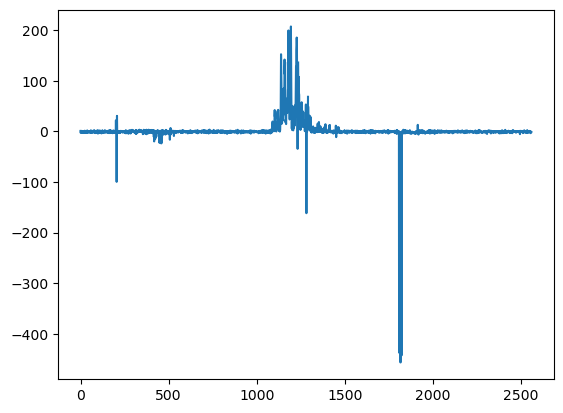

In [22]:
index=20
line=data[dh.det['hirex']]['data.adc'][index,:]
x=np.arange(len(line))
plt.plot(x, line)
check_for_spectrum(line)

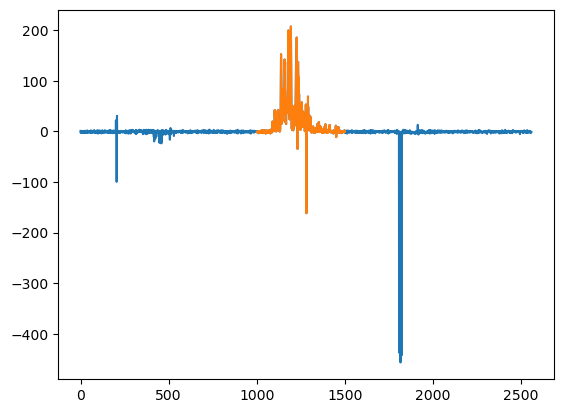

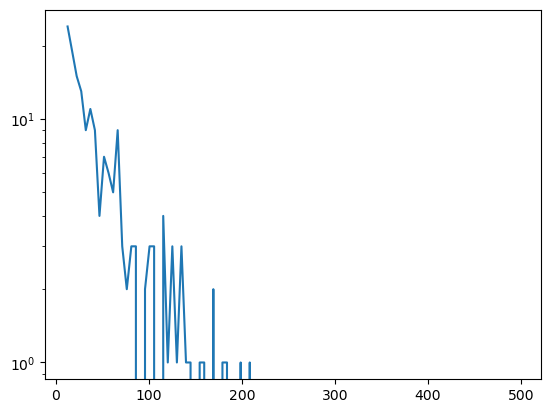

In [17]:
index=20
roi_min=1000
roi_max=1500
x=np.arange(len(data[dh.det['hirex']]['data.adc'][index,:]))
plt.plot(x, data[dh.det['hirex']]['data.adc'][index,:])
plt.plot(x[roi_min:roi_max], data[dh.det['hirex']]['data.adc'][index,roi_min:roi_max])
plt.show()
plt.plot(hist.centers(),hist(data[dh.det['hirex']]['data.adc'][index,roi_min:roi_max]))
plt.yscale('log')

In [25]:
data[dh.det['xgm2']].keys()

dict_keys(['metadata', 'data.ySa1TD', 'data.ySa3SigmaTD', 'data.xSigmaTD', 'data.intensitySa1TD', 'data.intensitySigmaTD', 'data.intensityAUXSa3TD', 'data.ySa3TD', 'data.yTD', 'data.ySa1SigmaTD', 'data.ySigmaTD', 'data.trainId', 'data.intensityAUXTD', 'data.xTD', 'data.intensityAUXSa1TD', 'data.intensitySa1SigmaTD', 'data.xSa1TD', 'data.xSa1SigmaTD', 'data.xSa3SigmaTD', 'data.intensitySa3TD', 'data.intensityTD', 'data.xSa3TD', 'data.intensitySa3SigmaTD'])

{'source': 'SPB_XTD9_XGM/XGM/DOOCS:output', 'timestamp.tid': 2270418343}